<a href="https://colab.research.google.com/github/talhaanwarch/COVID_Cardiac_diseases_diagnosis/blob/main/adamW_flip_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
!cp '/content/drive/MyDrive/data/ECG_paper/images.zip' '/content/'
!unzip /content/images.zip

In [3]:
%%capture
pip install efficientnet_pytorch

In [4]:
# !rm -rf /content/ecg_data
# !rm -rf /content/data

In [5]:
#add suffix to file names
import os
from glob import glob
for dir in os.listdir('/content/ecg_data'):
  for img in glob('ecg_data/{}/*.jpg'.format(dir)):
    os.rename(img,img[0:-4]+'_{}.jpg'.format(dir))


In [6]:
#create dataframe 
import pandas as pd
img_list=[]
img_label=[]
for dir in os.listdir('/content/ecg_data'):
  for img in glob('ecg_data/{}/*.jpg'.format(dir)):
    img_list.append(img)
    img_label.append(dir)

df=pd.DataFrame(zip(img_list,img_label),columns=['img','label'])
df.head()

,img,label
0,ecg_data/MI/262_MI.jpg,MI
1,ecg_data/MI/241_MI.jpg,MI
2,ecg_data/MI/255_MI.jpg,MI
3,ecg_data/MI/254_MI.jpg,MI
4,ecg_data/MI/222_MI.jpg,MI


In [7]:
df.label.value_counts()

Normal          859
HeartBeat       546
Covid           250
MI_recovered    203
MI               74
Name: label, dtype: int64

In [8]:
df.label=df.label.map({'Normal':0,'HeartBeat':1,'Covid':2,'MI_recovered':3,'MI':4})


In [9]:
#move all images to one folder
!mkdir data
!mv  /content/ecg_data/Covid/* /content/data
!mv  /content/ecg_data/HeartBeat/* /content/data
!mv  /content/ecg_data/MI/* /content/data
!mv  /content/ecg_data/MI_recovered/* /content/data
!mv  /content/ecg_data/Normal/* /content/data

In [10]:
!ls data -U | head -4

19_MI_recovered.jpg
83_MI_recovered.jpg
81_MI_recovered.jpg
100_Normal.jpg


In [11]:
df.img=df.img.apply(lambda x:'data/'+x.split('/')[-1])

In [12]:
df.head()

,img,label
0,data/262_MI.jpg,4
1,data/241_MI.jpg,4
2,data/255_MI.jpg,4
3,data/254_MI.jpg,4
4,data/222_MI.jpg,4


In [13]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:

#check version of pytorch
print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


In [16]:
#check gpu
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
Tesla P100-PCIE-16GB


In [17]:
device=torch.device('cuda')

In [18]:
class AdjustGamma(object):
    def __call__(self, img):
        return transforms.functional.adjust_gamma(img, 0.8, gain=1)
class AdjustContrast(object):
    def __call__(self, img):
        return transforms.functional.adjust_contrast(img, 2)
class AdjustBrightness(object):
    def __call__(self, img):
        return transforms.functional.adjust_brightness(img, 2)

In [19]:
#image augmentation
from torchvision import transforms 
aug=transforms.Compose([
                        transforms.Resize((300,300)),
                        transforms.RandomHorizontalFlip(p=0.7),transforms.RandomVerticalFlip(p=0.7),
                        # AdjustGamma(),
                        # AdjustContrast(),
                        # transforms.RandomPerspective(distortion_scale=0.1),   
                        # transforms.RandomResizedCrop((300,300)),                 
                        # transforms.CenterCrop(300),
                        
                        # transforms.GaussianBlur(5),
                        
                        transforms.ToTensor(),
                        #transforms.RandomErasing(p=0.2),
                        transforms.Normalize([0.5820, 0.4512, 0.4023], [0.2217, 0.1858, 0.1705]),

                        ])

In [20]:
class dfloader(torch.utils.data.Dataset):
    
    def __init__(self,img_id,img_label,transform=None):
        self.img_id = img_id    
        self.img_label=img_label
        self.transform=transform
        
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
          index = index.item()
        img_ind=self.img_id[index]
        label_ind=self.img_label[index]

        img = Image.open(img_ind).convert('RGB')
      
        if self.transform:
           img=self.transform(img) 
  
        return img ,label_ind
    
    def __len__(self):
        return len(self.img_id)

In [21]:
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
def effnet_model():
  model=EfficientNet.from_pretrained('efficientnet-b3')
  num_ftrs = model._fc.in_features
  model._fc = nn.Sequential(
                        nn.Linear(num_ftrs, 512), 
                        nn.ReLU(), 
                        nn.Dropout(0.5),
                        #nn.Linear(512, 256),  
                        #nn.ReLU(),
                        #nn.Dropout(0.25),
                        nn.Linear(512, 5),  
                        #nn.LogSoftmax(dim=1)
  )
  return model

In [22]:
from sklearn.metrics import classification_report,f1_score

def fit(train_loader,val_loader,test_loader,model,epoch=10,scheduler_step=None,verbose=None):
  from time import time
  train_loss_plt=[]
  val_loss_plt=[]
  train_acc_plt=[]
  val_acc_plt=[]
  for ep in range(epoch):
    start=time()
    #start training loop
    train_loss_sum=0
    train_acc_sum=0
    for train_batch in train_loader:
      train_img,train_label=train_batch
      train_img,train_label = train_img.to(device),train_label.to(device)

      train_out=model(train_img)
      train_loss=criterion(train_out,train_label)
  #     pt = torch.exp(-train_loss)
  #     train_loss = (alpha * (1-pt)**gamma * train_loss).mean() 
      opt.zero_grad()
      train_loss.backward()
      opt.step()
      train_loss_sum+=train_loss.item()
      train_acc_sum += ((torch.max(train_out,dim=1)[1]==train_label).sum().item())/len(train_label)
    #start validation loop
    val_loss_sum=0
    val_acc_sum=0
    model.eval()
    with torch.no_grad():
      for val_image,val_label in val_loader:
        val_image,val_label=val_image.to(device),val_label.to(device)
        val_out=model(val_image)
        val_loss=criterion(val_out,val_label)
  #       pt = torch.exp(-val_loss)
  #       val_loss = (alpha * (1-pt)**gamma * val_loss).mean() 
        val_loss_sum+=val_loss.item()
        val_acc_sum+=((torch.max(val_out,dim=1)[1]==val_label).sum().item())/len(val_label)
    end=np.round((time()-start)/60,2) #time in minute
    model.train()
    #calculate print and append the results for plotting purpose
    val_avg_loss=np.round(val_loss_sum/len(val_loader),2)#val loss of all batches of one epoch
    train_avg_loss=np.round(train_loss_sum/len(train_loader),2)# train loss of all batches of one epoch
    train_avg_acc=np.round(train_acc_sum/len(train_loader),2)#train acc of all batches of one epoch
    val_avg_acc=np.round(val_acc_sum/len(val_loader),2)#val acc of all batches of one epoch
    if scheduler_step:
      scheduler.step(val_avg_loss)
    if verbose:
      print('Epoch {}, time {} , train acc  {}, train loss {} , val acc is {}, loss is {}, learning rate is {} '.format
            (ep,end,train_avg_acc,train_avg_loss,val_avg_acc,val_avg_loss,opt.param_groups[0]['lr']))
    train_loss_plt.append(train_avg_loss)  #append loss of training data  
    val_loss_plt.append(val_avg_loss)     #append loss of validation data
    train_acc_plt.append(train_avg_acc)  #append acc of training data  
    val_acc_plt.append(val_avg_acc)     #append acc of validation data

  test_pred=[]
  test_actual=[]
  model.eval()
  with torch.no_grad():
    for img,grnd_label in test_loader:
      test_pred.append(model(img.to(device)))
      test_actual.append(grnd_label)
  test_pred=torch.cat(test_pred,dim=0)
  test_actual=torch.cat(test_actual,dim=0)
  y_pred=torch.max(test_pred,dim=1)
  y_pred=y_pred[1].cpu().numpy()
  test_actual=test_actual.numpy()
  report=classification_report(test_actual,y_pred)
  f1=f1_score(test_actual,y_pred,average='macro')
  return [train_loss_plt,val_loss_plt,train_acc_plt,val_acc_plt],[report,f1]


In [23]:
from sklearn.model_selection import KFold,StratifiedKFold
from torch.utils.data.dataloader import DataLoader

classification_reports=[]
kf = StratifiedKFold(n_splits=5)
graph,metric=[],[]
fold=0
for train_index, test_index in kf.split(df.img,df.label):
  train=df.iloc[train_index,:]
  test=df.iloc[test_index,:]
  print('-----------fold {}--------------'.format(fold))
  train=dfloader(train.img.values,train.label.values,transform=aug)
  test=dfloader(test.img.values,test.label.values,transform=aug)
  train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=32)
  val_loader = DataLoader(test,shuffle=True,num_workers=0,batch_size=32)
  #class weight
  target=[batch[1] for batch in train_loader]
  class_sample_count = torch.unique(torch.cat(target), return_counts=True)[1]
  weight = torch.true_divide(1,class_sample_count)
  #model initiate
  model=effnet_model()
  my_model=model.to(device)
  criterion=torch.nn.CrossEntropyLoss(weight=weight.to(device))
  opt=torch.optim.AdamW(params=my_model.parameters(),lr=0.0001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode ='min',factor=0.5, patience=5, verbose=True)
  #training
  res=fit(train_loader,val_loader,val_loader,my_model,epoch=15)
  graph.append(res[0]),metric.append(res[1])
  fold+=1
  del my_model

-----------fold 0--------------


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3
-----------fold 1--------------
Loaded pretrained weights for efficientnet-b3
-----------fold 2--------------
Loaded pretrained weights for efficientnet-b3
-----------fold 3--------------
Loaded pretrained weights for efficientnet-b3
-----------fold 4--------------
Loaded pretrained weights for efficientnet-b3


In [24]:
class_report=[]
for i in range(5):
  print(metric[i][0])
  class_report.append(metric[i][0])

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       172
           1       0.68      0.77      0.72       109
           2       1.00      0.96      0.98        50
           3       0.51      0.73      0.60        41
           4       0.75      0.60      0.67        15

    accuracy                           0.78       387
   macro avg       0.77      0.77      0.76       387
weighted avg       0.81      0.78      0.79       387

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       172
           1       0.81      0.72      0.77       109
           2       1.00      0.98      0.99        50
           3       0.80      0.68      0.74        41
           4       0.53      0.60      0.56        15

    accuracy                           0.84       387
   macro avg       0.80      0.78      0.79       387
weighted avg       0.84      0.84      0.84       387

              precisio

In [25]:
from functools import reduce
report_list=[]
for i in range(5):
  splited = [' '.join(x.split()) for x in class_report[i].split('\n\n')]
  header = [x for x in splited[0].split(' ')]
  data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
  data = np.delete(data, 0, 1).astype(float)
  x=splited[2].split(' ')[5::]
  x.remove('weighted')
  x.remove('avg')
  x=np.array([float(i) for i in x]).reshape(-1, len(header))
  index=['Normal','HeartBeat','Covid','MI_recovered','MI','macro','weighted']
  df = pd.DataFrame(np.concatenate((data, x)), columns=header,index=index)
  report_list.append(df)
print(reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list))

              precision  recall  f1-score  support
Normal            0.854   0.880     0.864    171.8
HeartBeat         0.762   0.744     0.752    109.2
Covid             0.992   0.952     0.972     50.0
MI_recovered      0.688   0.614     0.638     40.6
MI                0.662   0.700     0.676     14.8
macro             0.792   0.778     0.780    386.4
weighted          0.822   0.816     0.816    386.4


In [ ]:
np.save('graph.npy',graph)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


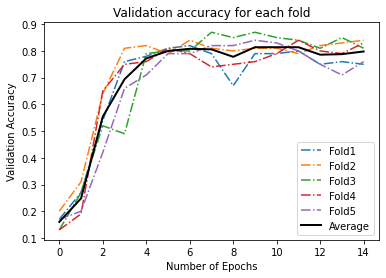

In [28]:
for i in range(5):
  plt.plot(graph[i][3],label='Fold{}'.format(i+1),linestyle='-.',linewidth=1.5)
plt.plot(np.mean([graph[i][3] for i in range(5)],axis=0),label='Average',linewidth=2,color='black')
plt.legend()
#plt.title('Model validation Accuracy ')
plt.xlabel('Number of Epochs',)
plt.ylabel('Validation Accuracy')
plt.savefig('adamW_flip_augmented.eps')
plt.title('Validation accuracy for each fold')
!cp '/content/adamW_flip_augmented.eps' '/content/drive/MyDrive/image'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


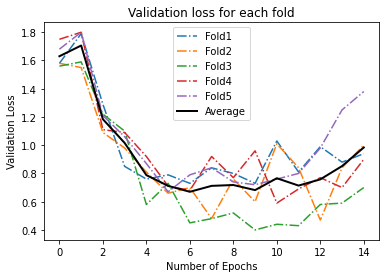

In [29]:
for i in range(5):
  plt.plot(graph[i][1],label='Fold{}'.format(i+1),linestyle='-.',linewidth=1.5)
plt.plot(np.mean([graph[i][1] for i in range(5)],axis=0),label='Average',linewidth=2,color='black')
plt.legend()
#plt.title('Model validation Accuracy ')
plt.xlabel('Number of Epochs',)
plt.ylabel('Validation Loss')
plt.savefig('adam_flip_augmented_loss.eps')
plt.title('Validation loss for each fold')
!cp '/content/adam_flip_augmented_loss.eps' '/content/drive/MyDrive/image'

Text(0.5, 1.0, 'Averaged Training and Validation Loss')

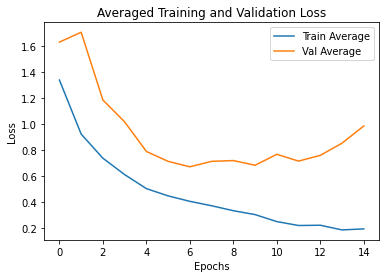

In [30]:
plt.plot(np.mean([graph[i][0] for i in range(5)],axis=0),label='Train Average')
plt.plot(np.mean([graph[i][1] for i in range(5)],axis=0),label='Val Average')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Averaged Training and Validation Loss')

Text(0.5, 1.0, 'Averaged Training and Validation Accuracy')

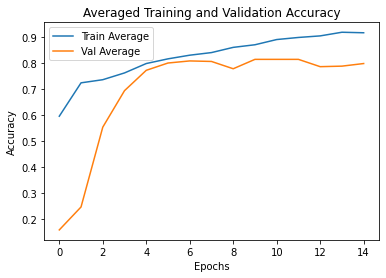

In [31]:
plt.plot(np.mean([graph[i][2] for i in range(5)],axis=0),label='Train Average')
plt.plot(np.mean([graph[i][3] for i in range(5)],axis=0),label='Val Average')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Averaged Training and Validation Accuracy')

In [32]:
val=['train_loss','val_loss','train_acc','val_acc']
for j,k in enumerate(val):
  print(k,np.mean([graph[i][j] for i in range(5)],axis=0))

train_loss [1.338 0.922 0.736 0.61  0.502 0.446 0.404 0.37  0.332 0.302 0.248 0.218
 0.22  0.184 0.192]
val_loss [1.63  1.706 1.184 1.016 0.788 0.712 0.67  0.712 0.718 0.682 0.766 0.714
 0.758 0.852 0.984]
train_acc [0.596 0.724 0.736 0.762 0.798 0.816 0.83  0.84  0.86  0.87  0.89  0.898
 0.904 0.918 0.916]
val_acc [0.16  0.248 0.554 0.694 0.772 0.8   0.808 0.806 0.778 0.814 0.814 0.814
 0.786 0.788 0.798]
